In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph/myKernels')
#from importlib import reload
#reload(readfoldertopanda)
import mmdutils
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
from myKernels import RandomWalk as rw
import WL

In [26]:
from importlib import reload  
foo = reload(mg)

n_1 = 50
n_2 = 50
nnode_1 = 70
nnode_2 = 70

p = [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)]
q = [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2)   for i in range(n_2)]#[np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)] # [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)]

6.4489
4.805
bg1 = mg.BinomialGraphs(n_1, nnode_1, k = 4, l = 'alldistinctlabels', fullyConnected = True)
bg2 = mg.BinomialGraphs(n_2, nnode_2, k = 5, l = 'alldistinctlabels', fullyConnected = True)
bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

In [3]:
# from scipy.sparse.linalg import eigsh
# import scipy
# w, u = eigsh(scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(Gs[0]), dtype=np.float64), k = 3)

In [4]:
importlib.reload(sys.modules['WL'])
wl_graphs = WL.WL()
X, new_labels = wl_graphs.fit_transform(Gs, 4)

In [5]:
def issymmetric(a, rtol=1e-05, atol=1e-08):
    """
    Check if matrix is symmetric
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [6]:
# G1 = Gs[51]
# G2 = Gs[21]
# A1 = nx.linalg.adjacency_matrix(G1).todense()
# A2 = nx.linalg.adjacency_matrix(G2).todense()

# np.dot(np.kron(q[0],q[21]), np.kron(A1,A2)).dot(np.kron(p[0],p[21]))


In [7]:
#np.mean([nx.density(G) for G in Gs[:n_1]])

In [8]:
#np.mean([nx.density(G) for G in Gs[n_1:]])


In [9]:
# G1.nodes(True)

In [10]:
# degree1 = np.array(list(dict(G1.degree()).values()))
# degree2 = np.array(list(dict(G2.degree()).values()))

# (1/G1.number_of_nodes()) * (1/G2.number_of_nodes()) *np.sum([d_i*degree2 for d_i in degree1])


In [11]:
[0.0, 1.0/((nnode_1-1.0)*(nnode_2-1.0)), 1.0]

[0.0, 0.00041649312786339027, 1.0]

In [27]:
importlib.reload(sys.modules['MMDforGraphs'])
bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

# Grakel kernels
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)   
#kernel = [{"name": "weisfeiler_lehman", "n_iter": 4}, {"name": "vertex_histogram"}]
kernel = [{"name": "WL-OA", "n_iter": 4}]
# kernel = [{"name": "SP", "with_labels": 1}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
# kernel = [{"name": "pyramid_match", "with_labels":False, "d":2, "L":4}] 
#kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
# kernel = [{"name":'odd_sth', 'h':3}]
#kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "propagation", "t_max": 2, "w":0.01, "M":'TV'}]

init_kernel = gk.GraphKernel(kernel= kernel, normalize=1, n_jobs= 4)
#K = init_kernel.fit_transform(graph_list)

# My kernels
# RW kernel
# label list for rw
label_list = []
for G in Gs:
    label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

# label_list = np.unique(np.concatenate(label_list))
rw_kernel = rw.RandomWalk(Gs, c = 0.01, normalize=0, p = p, q = q )
# K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
K = rw_kernel.fit_ARKU_plus(r = 12, normalize_adj=False)
# K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))

print(np.all(K == 0)) 
print(K)


MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000, method = 'BootstrapScheme')

# Run power
#threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
#print(f'threshold {threshold}')
#ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n_1)
#print(f'V {V}')
#print(f'ratio {ratio}')
#print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

100%|██████████| 5050/5050.0 [00:12<00:00, 401.61it/s]


False
[[5986.21746921 6065.71629164 5766.46668033 ... 6274.31055643
  6287.90317301 6505.84887954]
 [6065.71629164 6155.00380761 5828.61617228 ... 6389.42766288
  6401.41827237 6647.12997749]
 [5766.46668033 5828.61617228 5591.58408783 ... 5991.67829983
  6003.33939878 6173.50993781]
 ...
 [6274.31055643 6389.42766288 5991.67829983 ... 6692.81762318
  6700.19395164 7020.98194327]
 [6287.90317301 6401.41827237 6003.33939878 ... 6700.19395164
  6709.56682697 7024.65279776]
 [6505.84887954 6647.12997749 6173.50993781 ... 7020.98194327
  7024.65279776 7422.64415315]]
p_value {'MMD_b': 0.0, 'MMD_u': 0.0}
MMD_u 146.57116507866704


Text(0.5, 1.0, 'H1 True')

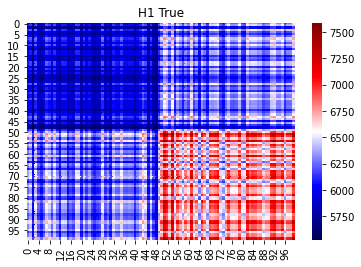

In [29]:
#np.fill_diagonal(K,0)
ax = plt.axes()
sns.heatmap(K, cmap='seismic')

ax.set_title(f'H1 True')